## CloudDBH

In [51]:
import numpy as np
import pandas as pd
import glob
import sys
import os
import gc
import open3d as o3d

from shapely.ops import cascaded_union, polygonize
from shapely.geometry import Polygon, LineString
import shapely.geometry as geometry

from scipy import optimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
import scipy.io as sio

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import math
from math import pi

from sklearn.neighbors import NearestNeighbors
from descartes import PolygonPatch


# Functions

### From Calders et al. 

In [52]:
# Functions from Calders et al
# nearest neighbour needed for outlier removal
def nn(x,rad):
    """
    Function from TLS_Inventory.
    
    x: a numpy array, rad: radius to search for neighbors within
    
    My understanding - can either specify number of neighbors to return (in sklearn NearestNeighbors),
    or return all the neighbors and then filter to return only those within a specified distance radius
    """
    nbrs = NearestNeighbors(algorithm='auto', metric='euclidean').fit(x) 
    distances, indices = nbrs.radius_neighbors(radius=rad) #find all neighbours within this search radius
    
    #output explained: https://stackoverflow.com/questions/53886289/confused-with-the-output-of-sklearn-neighbors-nearestneighbors 
    return distances, indices


def load_pts(cloud,downsample=False,outliers=False): 
    """
    Function from TLS_Inventory that reads the point cloud data for single tree at a time and
    returns pandas dataframe with the points split into x, y, z coordinates. 
    
    cloud: point cloud from a single tree - note, point cloud data should be pre-processed and 
           split into individual trees prior to using this function.
    downsample (Optional): Default is False, meaning all the points are retained. If 
                           True, the point clouds are sampled to keep only fraction of points.
    outliers (Optional): Default is False, meaning outliers are retained. If True, 
    """
    # read the point cloud data for single tree and save as pandas df with columns for x, y, z coords
    dftemp=o3d.io.read_point_cloud(cloud)
    df=pd.DataFrame(data=np.asarray(dftemp.points),columns=['x', 'y', 'z']) #access the points
    
    # Optional downsampling
    if downsample:
        df=df.sample(frac=0.1) # keep 10pct of points
    
    # Optional outlier removal 
    if outliers: #remove outliers
        xy=df.iloc[:,0:2].values # takes ALL rows, first and second column - x and y - and .values converts to numpy array
        dist, indi = nn(xy,0.5) # get nearest neighbors within search radius of 0.5
        cnt=[len(i) for i in indi] # count the kNN within the search radius
        cnt = pd.DataFrame({'count':cnt})
        
        # set threshold for the number of neighbors we want to keep 
        threshold=df.shape[0]*0.0001 #1 neighbor for every 10 000 pts
        
        removed=sum(np.array(cnt)<threshold)
        df=df[np.array(cnt)>=threshold]
        print("Removed %i outliers using kNN threshold %.2f" % (removed[0], threshold-1))
    
    return df #return pandas dataframe 

### Helper Functions

In [53]:
# TODO: dont use this format plots function find a package
def formatplots(trees, ncols=4, shape='square'):
    # determine number of subplots
    nplots = len(trees)
    
    # determine number of rows 
    if(nplots % ncols) != 0:
        nrows = int(nplots / ncols + 1)
    else:
        nrows = int(nplots / ncols)

    if shape == 'horiz':
        # initiate figure with nrows and ncols
        fig, axs = plt.subplots(nrows, ncols, figsize=(20,nrows*4))
        fig.tight_layout()
    if shape == 'vert':
        # initiate figure with nrows and ncols
        fig, axs = plt.subplots(nrows, ncols, figsize=(20,nrows*10))
        fig.tight_layout()
    if shape == 'square':
        # initiate figure with nrows and ncols
        fig, axs = plt.subplots(nrows, ncols, figsize=(20,nrows*5))
        fig.tight_layout()
    
    return fig, axs

In [54]:
def update_inds(treeind, rowind, colind, ncols):
    # increase tree index to get to next tree
    treeind += 1

    if (treeind % ncols) != 0:
        colind += 1
    else:
        rowind +=1 
        colind = 0
    
    return treeind, colind, rowind

In [55]:
def construct_treeid(tree, ptspath):
    # For wytham woods tree dataset
    if str(ptspath).__contains__('DATA_clouds_ply'):
        if tree[-4:] != '.ply':
            tree = str(ptspath) + '/wytham_winter_' + str(tree) + '.ply' # TODO: don't hard code this
        else:
            tree = tree # TODO: make this more robust

        tree_num = tree.split("_")[-1].split(".")[0]
    
    # For tropical tree dataset - must have the leaf files already removed
    if str(ptspath).__contains__('Tropical_manual_ply'):
        if tree[-4:] != '.ply':
            tree = str(ptspath) + '/MLA01_2018_' + str(tree) + '.wood.ply' # TODO: don't hard code this
        else:
            tree = str(tree) # TODO: make this more robust

        tree_num = tree.split("_")[-1].split(".")[0]
    return tree, tree_num

In [56]:
def wytham_singlemulti(ptspath):
    """
    Function that splits the wytham woods dataset into single vs multistemmed trees 
    with string operations based on how the wytham dataset is named.
    """

    singlestemmed = []
    multistemmed = []
    
    # get list of trees from pts path
    trees = glob.glob("%s/*ply" % pts_path)
    
    for tree in trees:
        tree_num = tree.split("_")[-1].split(".")[0]
        
        # if the treeID ends in a letter, it is not single stem
        if tree_num[-1].isalpha():
            multistemmed.append(tree)
        else:
            singlestemmed.append(tree)

    return singlestemmed, multistemmed

### Tree Functions

In [57]:
def calc_convexhull(tree, ptspath, hgt=1.3):
    """
    Function to calculate and plot convex hulls for each tree in a list of trees.
    
    Returns: 
        dbh - value for diameter at the specified height 
        verts - number of vertices used in calculating convex hull 
        pts_dbh - the 3D point dataset for the given slice (for plotting)
    """

    # Get treeID and ensure inputted format is correct
    tree, tree_num = construct_treeid(tree, ptspath)

    # get DBH from full cloud to preserve max number of hits on stem slice
    pts = load_pts(tree,False,False)

    # extract part of df with z values between 1.27 and 1.33 m by default - Tansey et al. 2009, Calders et al. 2015
    pts_dbh = pts[(pts['z'] > pts['z'].min() + hgt - 0.03) & (pts['z'] < pts['z'].min() + hgt + 0.03)]
    xy_dbh_arr = np.asarray(pts_dbh[['x', 'y']])

    # Calculate DBH (convex hull) using scipy ConvexHull
    hull = ConvexHull(xy_dbh_arr)
    
    # calculate return values
    dbh = hull.area / np.pi
    verts = len(hull.vertices)
                      
    return dbh, verts, pts_dbh, hull
    

In [58]:
# TODO: redo this function so it takes in better args
def plot_convexhull(treelist, ptspath, ncols=4, fixedheight = True, hgt=1.3, hgtlist = None):
    fig, axs = formatplots(treelist, ncols)
    rowind = colind = treeind = 0
    
    for tree in treelist:
        tree, tree_num = construct_treeid(tree, ptspath)
        
        if fixedheight:
            hgt = hgt
        else:
            hgt = hgtlist[tree_num]
        
        dbh_cv, verts, pts_dbh, hull = calc_convexhull(tree, pts_path, hgt=hgt)
        xy_dbh_arr = np.asarray(pts_dbh[['x', 'y']])
        
        
        axs[rowind, colind].scatter(pts_dbh['x'], pts_dbh['y']) 
        
        # plot line connecting all the dbh vertices
        for simplex in hull.simplices:
            axs[rowind, colind].plot(xy_dbh_arr[simplex, 0], xy_dbh_arr[simplex, 1], 'r--')
        
        axs[rowind, colind].plot(xy_dbh_arr[hull.vertices,0], xy_dbh_arr[hull.vertices,1], 'r--', label=f"DBH: {dbh_cv:.3f}") # DBH (convex hull)
        axs[rowind, colind].plot(xy_dbh_arr[hull.vertices,0], xy_dbh_arr[hull.vertices,1], 'ro', label=f"Vertices: {len(hull.vertices)}") # vertices

        axs[rowind, colind].set_title(f'DBH (Convex Hull) for {tree_num}')
        axs[rowind, colind].legend(fontsize='xx-large', loc='upper left')
        axs[rowind, colind].axis('equal')

        treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)
    return

In [59]:
def iter_dbh(tree, ptspath, step=0.1, lim=15, verbose=False):
    """
    Start from bottom of tree and calculate convex hull in 0.06m slices separated
    by defined step size until limit. 
    """

    # Get treeID
    tree, tree_num = construct_treeid(tree, ptspath)

    #get DBH from full cloud to preserve max number of hits on stem slice
    pts = load_pts(tree,False,False)

    # calculate dbh for slices up to smaller of lim or tree height
    disc = 0.1
    hgt = pts['z'].max() - pts['z'].min()
    
    # set the limit equal to the smaller of tree height and defined limit
    lim = min(hgt, lim)
    
    # empty lists to hold values for each tree
    dbh_list = []
    vert_list = []
    disc_list = []

    # loop upward through height of tree (up to lim)
    while disc < lim:
        # Calculate DBH (convex hull) for current slice using scipy ConvexHull
        pts_slice = pts[(pts['z'] > pts['z'].min() + disc - 0.03) & (pts['z'] < pts['z'].min() + disc + 0.03)]
        xy_dbh = np.asarray(pts_slice[['x', 'y']])

        if len(xy_dbh) < 3:
            if verbose: print(f'tree {tree_num} had not enough points at disc {disc}')
            dbh_list.append(np.nan)
            vert_list.append(np.nan)
            disc_list.append(round(disc, 1))
            disc += step
            continue

        circum = ConvexHull(xy_dbh) 
        
        dbh = circum.area / np.pi
        verts = len(circum.vertices)

        # append data to lists
        dbh_list.append(dbh)
        vert_list.append(verts)
        disc_list.append(round(disc, 1))

        # move up to next slice  
        disc += step
    
    df_out = pd.DataFrame(list(zip(dbh_list, vert_list, disc_list)), columns = ['DBH_CV', 'DBH_Verts', 'Slice_Hgt'])
    
    return df_out
            

In [67]:
def plot_iter_dbh(treelist, ptspath, ncols = 2, step=0.1, slope_thresh=0.1, dbh_thresh=2):
    """
    Takes the output of function iter_dbh and plots results in grid.
    """
    
    # format plotting grid
    fig, axs = formatplots(treelist, ncols, shape='horiz')
    rowind = colind = treeind = 0

    for tree in treelist:
        
        # Get treeID
        tree, tree_num = construct_treeid(tree, ptspath)
        
        # get dataframe of iterdbh function
        treedf = iter_dbh(tree, ptspath, step=step, lim=15)
        
        # get height for dbh for the tree 
        hgt = get_dbh_hgt(tree, ptspath, step=step, slope_thresh=slope_thresh, dbh_thresh=dbh_thresh)
        hgtplot = treedf['Slice_Hgt'] == hgt
        
        # get buttress height 
        buttress_hgt, treedf = get_buttress_hgt(tree, ptspath, step=step, lim=15, slope_thresh = slope_thresh)
        buttressplot = treedf['Slice_Hgt'] == buttress_hgt
        
        
        # plot data
        axs[rowind, colind].scatter(treedf['Slice_Hgt'], treedf['DBH_CV'])
        axs[rowind, colind].set_title(f'DBH w Height for {tree_num}', fontsize=20)
        axs[rowind, colind].set_xlabel('Height of DBH Slice (m)', fontsize=20)
        axs[rowind, colind].set_ylabel('Value of DBH Slice (m)', fontsize=20)
        axs[rowind, colind].plot(treedf['Slice_Hgt'][hgtplot], treedf['DBH_CV'][hgtplot],'r+', markersize=30)
        axs[rowind, colind].plot(treedf['Slice_Hgt'][buttressplot], treedf['DBH_CV'][buttressplot],'b+', markersize=30)
        
        #axs[rowind, colind].plot(treedf['Slice_Hgt'][filt], treedf['DBH_CV'][filt],'r+', markersize=20)
        #axs[rowind, colind].plot(treedf['Slice_Hgt'][buttress], treedf['DBH_CV'][buttress],'b+', markersize=20)
        
        fig.tight_layout()

        
        treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)
    
    return

In [61]:
def get_buttress_hgt(tree, ptspath, step=0.1, lim=15, slope_thresh = 0.1):
    """
    Parameters:
    tree - 
    ptspath - 
    step - 
    lim - 
    slope_thresh - slope threshold above which points are flagged as part of a buttress
    """
    
    # Get treeID
    tree, tree_num = construct_treeid(tree, ptspath)
    
    # run iterative dbh for specified step size and lim to calc slopes
    treedf = iter_dbh(tree, ptspath, step=step, lim=lim)
    
    # calculate slope between pair of dbh measurements
    for disc in treedf['Slice_Hgt'].iloc[1:-1]:

        # round disc heights to one decimal place
        disc = round(disc, 1)
        prev_disc = round(disc - step, 1)

        # get dbh values at each disc height
        val1 = treedf[treedf['Slice_Hgt'] == disc]['DBH_CV'].iloc[0]
        val2 = treedf[treedf['Slice_Hgt'] == prev_disc]['DBH_CV'].iloc[0]

        # calculate slope between dbh measurements
        slope = (val1 - val2) / step

        # make new column in treedf for slope
        treedf.loc[treedf['Slice_Hgt'] == prev_disc, 'slope'] = slope

        # flag slope values greater than given threshold
        if abs(slope) > slope_thresh:
            treedf.loc[treedf['Slice_Hgt'] == prev_disc, 'Buttress'] = 1

        else:
            treedf.loc[treedf['Slice_Hgt'] == prev_disc, 'Buttress'] = 0
        
    # if first three points are not flagged as buttress points:
    if all(np.array(treedf['Buttress'].iloc[0:3]) == np.array([0, 0, 0])):
        # set buttress height to 0.0 (i.e. bottom of tree stem)
        buttress_index = 0
        buttress_hgt = 0.0

    # otherwise, find height of top of buttress
    else:
        try:
            # find first sequence of five 0's (non-buttress points) 
            val_find = np.array([0, 0, 0])
            df_condition = treedf['Buttress'].rolling(3).apply(lambda g: all(g.astype(int) == val_find), raw=True)
            
            # get the index where five 0's first occurs and height of buttress
            buttress_index = np.where(df_condition == 1)[0][0]
            buttress_hgt = treedf['Slice_Hgt'].iloc[buttress_index]
        
        except:
            print(f"tree {tree_num}: no suitable place to measure dbh from. Setting buttress height to 1m by default.")
            
            # get the index where five 0's first occurs and height of buttress
            buttress_hgt = 1
               
    return buttress_hgt, treedf

In [62]:
# TODO: lim should be set outside functions to be equal to default or tree height, whichever is less
def flag_irregular(tree, ptspath, step=0.1, slope_thresh=0.1, lim=15, dbh_thresh = 2):
    """
    Flag any irregular parts of the tree stem to avoid using them for dbh.
    
    Using a rolling mean to easily account for/ avoid the influence of extremely 
    small outliers that may be caused by data occlusion. 
    """
    # run iterative dbh for specified step size and lim to calc slopes
    treedf = iter_dbh(tree, ptspath, step=step, lim=lim)
    
    # get buttress height and subset dataframe to parts over the buttress
    buttress_hgt, treedf = get_buttress_hgt(tree, ptspath, step=0.1, lim=lim, slope_thresh=slope_thresh)
    over_buttress = treedf[treedf["Slice_Hgt"] > buttress_hgt]
    
    # calculate a max dbh threshold - no greater 2 * minimum rolling mean dbh
    dbh_thresh = np.nanmin(over_buttress['DBH_CV'].rolling(3).mean()) * dbh_thresh
    
    # create a filter using this threshold
    dbh_filt = treedf['DBH_CV'] > dbh_thresh
    
    # flag values greater than the threshold
    treedf.loc[dbh_filt, 'Flagged'] = 1
    treedf.loc[~dbh_filt, 'Flagged'] = 0

    return treedf

In [68]:
def get_dbh_hgt(tree, ptspath, step=0.1, slope_thresh=0.1, lim=12, dbh_thresh = 2):
    """
    Take output of iter_dbh function and determine ideal height from which to calculate dbh
    
    Note: the rolling search doesn't seem to work if there is no buttress so this is broken up into 
    if else - TODO: but could simplify if I figure out how to fix the else part of the code to work
    for non buttressed trees too 
    """
    # Get treeID
    tree, tree_num = construct_treeid(tree, ptspath)

    # get buttress height
    buttress_hgt, treedf = get_buttress_hgt(tree, ptspath, step=step, lim=lim, slope_thresh=slope_thresh)
    
    # flag irregular points to be excluded from dbh height consideration
    treedf = flag_irregular(tree, ptspath, step=step, slope_thresh=slope_thresh, lim=lim, dbh_thresh = dbh_thresh)

    # subset treedf to only above buttress height
    over_buttress = treedf[treedf["Slice_Hgt"] > buttress_hgt]
    
    # select only non-flagged data
    filt = over_buttress['Flagged'] == 1
    validdf = over_buttress[~filt]

    # get suitable value closest to 1.3m to use for dbh height
    disclist = list(validdf['Slice_Hgt'])
    dif = lambda disclist : abs(disclist - 1.3)
    hgt = min(disclist, key=dif)

    return hgt

In [64]:
def plot2D(trees, ptspath, ncols=4, dbh=True, iterdbh=False, hgtlist = None):
    """
    Function to plot tree point clouds in x/z or y/z direction
    
    TODO: make iter dbh function work on just one tree - then call iter_dbh from within this function
    """
    # determine number of rows to plot figures
    fig, axs = formatplots(trees, ncols)
    rowind = colind = treeind = 0

    # loop through trees
    for tree in trees:
        # Get treeID
        tree, tree_num = construct_treeid(tree, ptspath)

        #get DBH from full cloud to preserve max number of hits on stem slice
        pts = load_pts(tree,False,False)

        # calculate tree height
        tree_hgt = pts['z'].max() - pts['z'].min()
            
        max_pt = pts[pts['z'] == pts['z'].max()]

        # plot scatter plot of points in x and z 
        axs[rowind, colind].scatter(pts['x'], pts['z'], s=3) 
        if dbh: 
            pts_dbh = pts[(pts['z'] > pts['z'].min() + 1.27) & (pts['z'] < pts['z'].min() + 1.33)]
            axs[rowind, colind].plot(pts_dbh['x'], pts_dbh['z'], 'ro', markersize=3, label=f"DBH Slice")
        
        if iterdbh: 
            hgt = hgtlist[tree_num]
            pts_hgt = pts[(pts['z'] > pts['z'].min() + hgt - 0.03) & (pts['z'] < pts['z'].min() + hgt + 0.03)]
            axs[rowind, colind].plot(pts_hgt['x'], pts_hgt['z'], 'yo', markersize=3, label=f"HGT Slice")
            

        axs[rowind, colind].annotate(f'Height: {tree_hgt:.2f}', xy=(max_pt['x'].iloc[0], max_pt['z'].iloc[0]), va='top', ha='left', size=15)
        axs[rowind, colind].legend(fontsize='xx-large', loc='upper left')
        axs[rowind, colind].set_title(f'{tree_num} ({rowind}, {colind})')

        # increase tree index to get to next tree
        treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)
    return



# Main Code

In [15]:
# Wytham Woods
pts_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_clouds_ply"
qsm_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/"
tree_csv_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/Calders Et Al/analysis_and_figures/trees_summary.csv"

# Tropical Trees
trop_pts_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Tropical_manual_ply'
trop_csv_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/MLA01_man.csv'

In [16]:
# Get lists of wytham and tropical trees
wytham_trees = glob.glob("%s/*ply" % pts_path)
trop_trees = glob.glob("%s/*wood.ply" % trop_pts_path)

# Split wytham trees into single/multi stemmed
singlestemmed, multistemmed = wytham_singlemulti(pts_path)

print(f'Singlestemmed: {len(singlestemmed)}')
print(f'Multistemmed: {len(multistemmed)}')

Singlestemmed: 585
Multistemmed: 291


In [17]:
len(trop_trees)

175

## Get DBH Heights, Calculate Convex Hull

In [69]:
# create empty dictionaries to hold data
hgt_dict = {}
dbh_13_dict = {}
dbh_adj_dict = {}

# set list of trees to run convex hull on 
treelist = trop_trees

# set threshold values for buttress slope and trunk irregularities
slope_thresh = 0.1
dbh_thresh = 2


# cycle through trees and fill dictionaries with optimal height and convex hull values
for tree in treelist:
    tree, tree_num = construct_treeid(tree, trop_pts_path)
    
    # calculate convex hull at 1.3m
    dbh_13, verts_13, pts_dbh_13, hull_13 = calc_convexhull(tree, trop_pts_path, hgt=1.3)
    dbh_13_dict[tree_num] = dbh_13
    
    # determine optimal height from which to calculate dbh
    hgt = get_dbh_hgt(tree, trop_pts_path, step=0.1, slope_thresh=slope_thresh, lim=12, dbh_thresh=dbh_thresh)
    hgt_dict[tree_num] = hgt
    
    #print(f'{tree_num} hgt: {hgt}')
    
    # calculate convex hull at optimal height 
    dbh_adj, verts_adj, pts_dbh_adj, hull_adj = calc_convexhull(tree, trop_pts_path, hgt=hgt)
    dbh_adj_dict[tree_num] = dbh_adj
    

tree T2605: no suitable place to measure dbh from. Setting buttress height to 1m by default.
tree T2605: no suitable place to measure dbh from. Setting buttress height to 1m by default.
tree T80: no suitable place to measure dbh from. Setting buttress height to 1m by default.
tree T80: no suitable place to measure dbh from. Setting buttress height to 1m by default.


In [70]:
# convert each dictionary to dataframe and rename columns
hgt = pd.DataFrame.from_dict(hgt_dict, orient='index').reset_index()
hgt.columns = ['TLS_ID', 'hgt']

dbh13 = pd.DataFrame.from_dict(dbh_13_dict, orient='index').reset_index()
dbh13.columns = ['TLS_ID', 'dbh13']

dbhadj = pd.DataFrame.from_dict(dbh_adj_dict, orient='index').reset_index()
dbhadj.columns = ['TLS_ID', 'dbhadj']

# create dataframe for the list of trees with optimal height and convex hull values
trop_treedata = pd.merge(pd.merge(hgt, dbh13, on ='TLS_ID'), dbhadj, on ='TLS_ID')

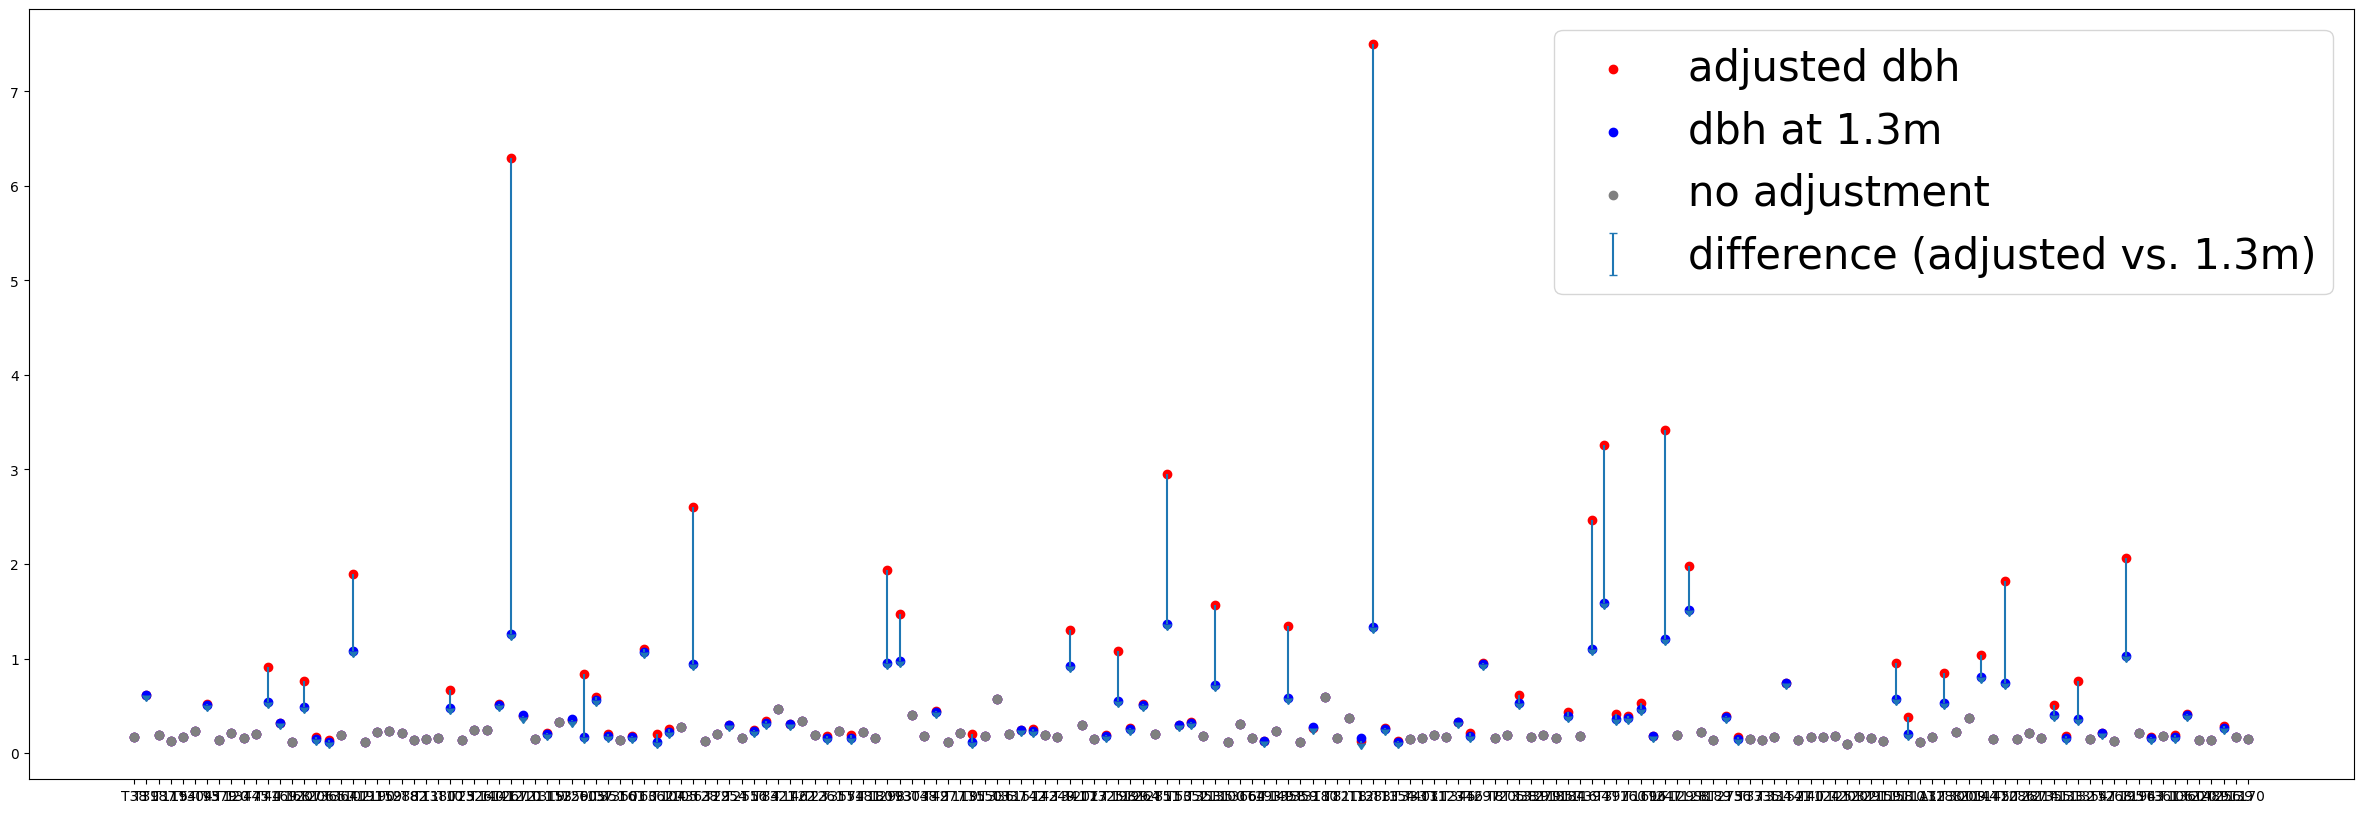

In [110]:
# plot the height at which dbh is measured for each tree (note most at 1.3m)
fig = plt.figure(figsize=(30, 10))

# create dataset of only the points where the adjusted dbh height was 1.3 to mask these values
mask13 = trop_treedata[trop_treedata['hgt'] == 1.3]

plt.scatter(trop_treedata['TLS_ID'], trop_treedata['dbh13'], color='red', label="adjusted dbh")
plt.scatter(trop_treedata['TLS_ID'], trop_treedata['dbhadj'], color='blue', label="dbh at 1.3m")
plt.scatter(mask13['TLS_ID'], mask13['dbh13'], color='gray', label="no adjustment") # mask points where adjusted dbh height was 1.3

yerr = abs(trop_treedata['dbhadj'] - trop_treedata['dbh13'])
plt.errorbar(trop_treedata['TLS_ID'], trop_treedata['dbh13'], yerr, uplims=yerr, ls='none', label="difference (adjusted vs. 1.3m)")

plt.legend(loc="upper right", fontsize=30)

## Plot Some Results

In [21]:
plotlist = trop_trees[0:20]

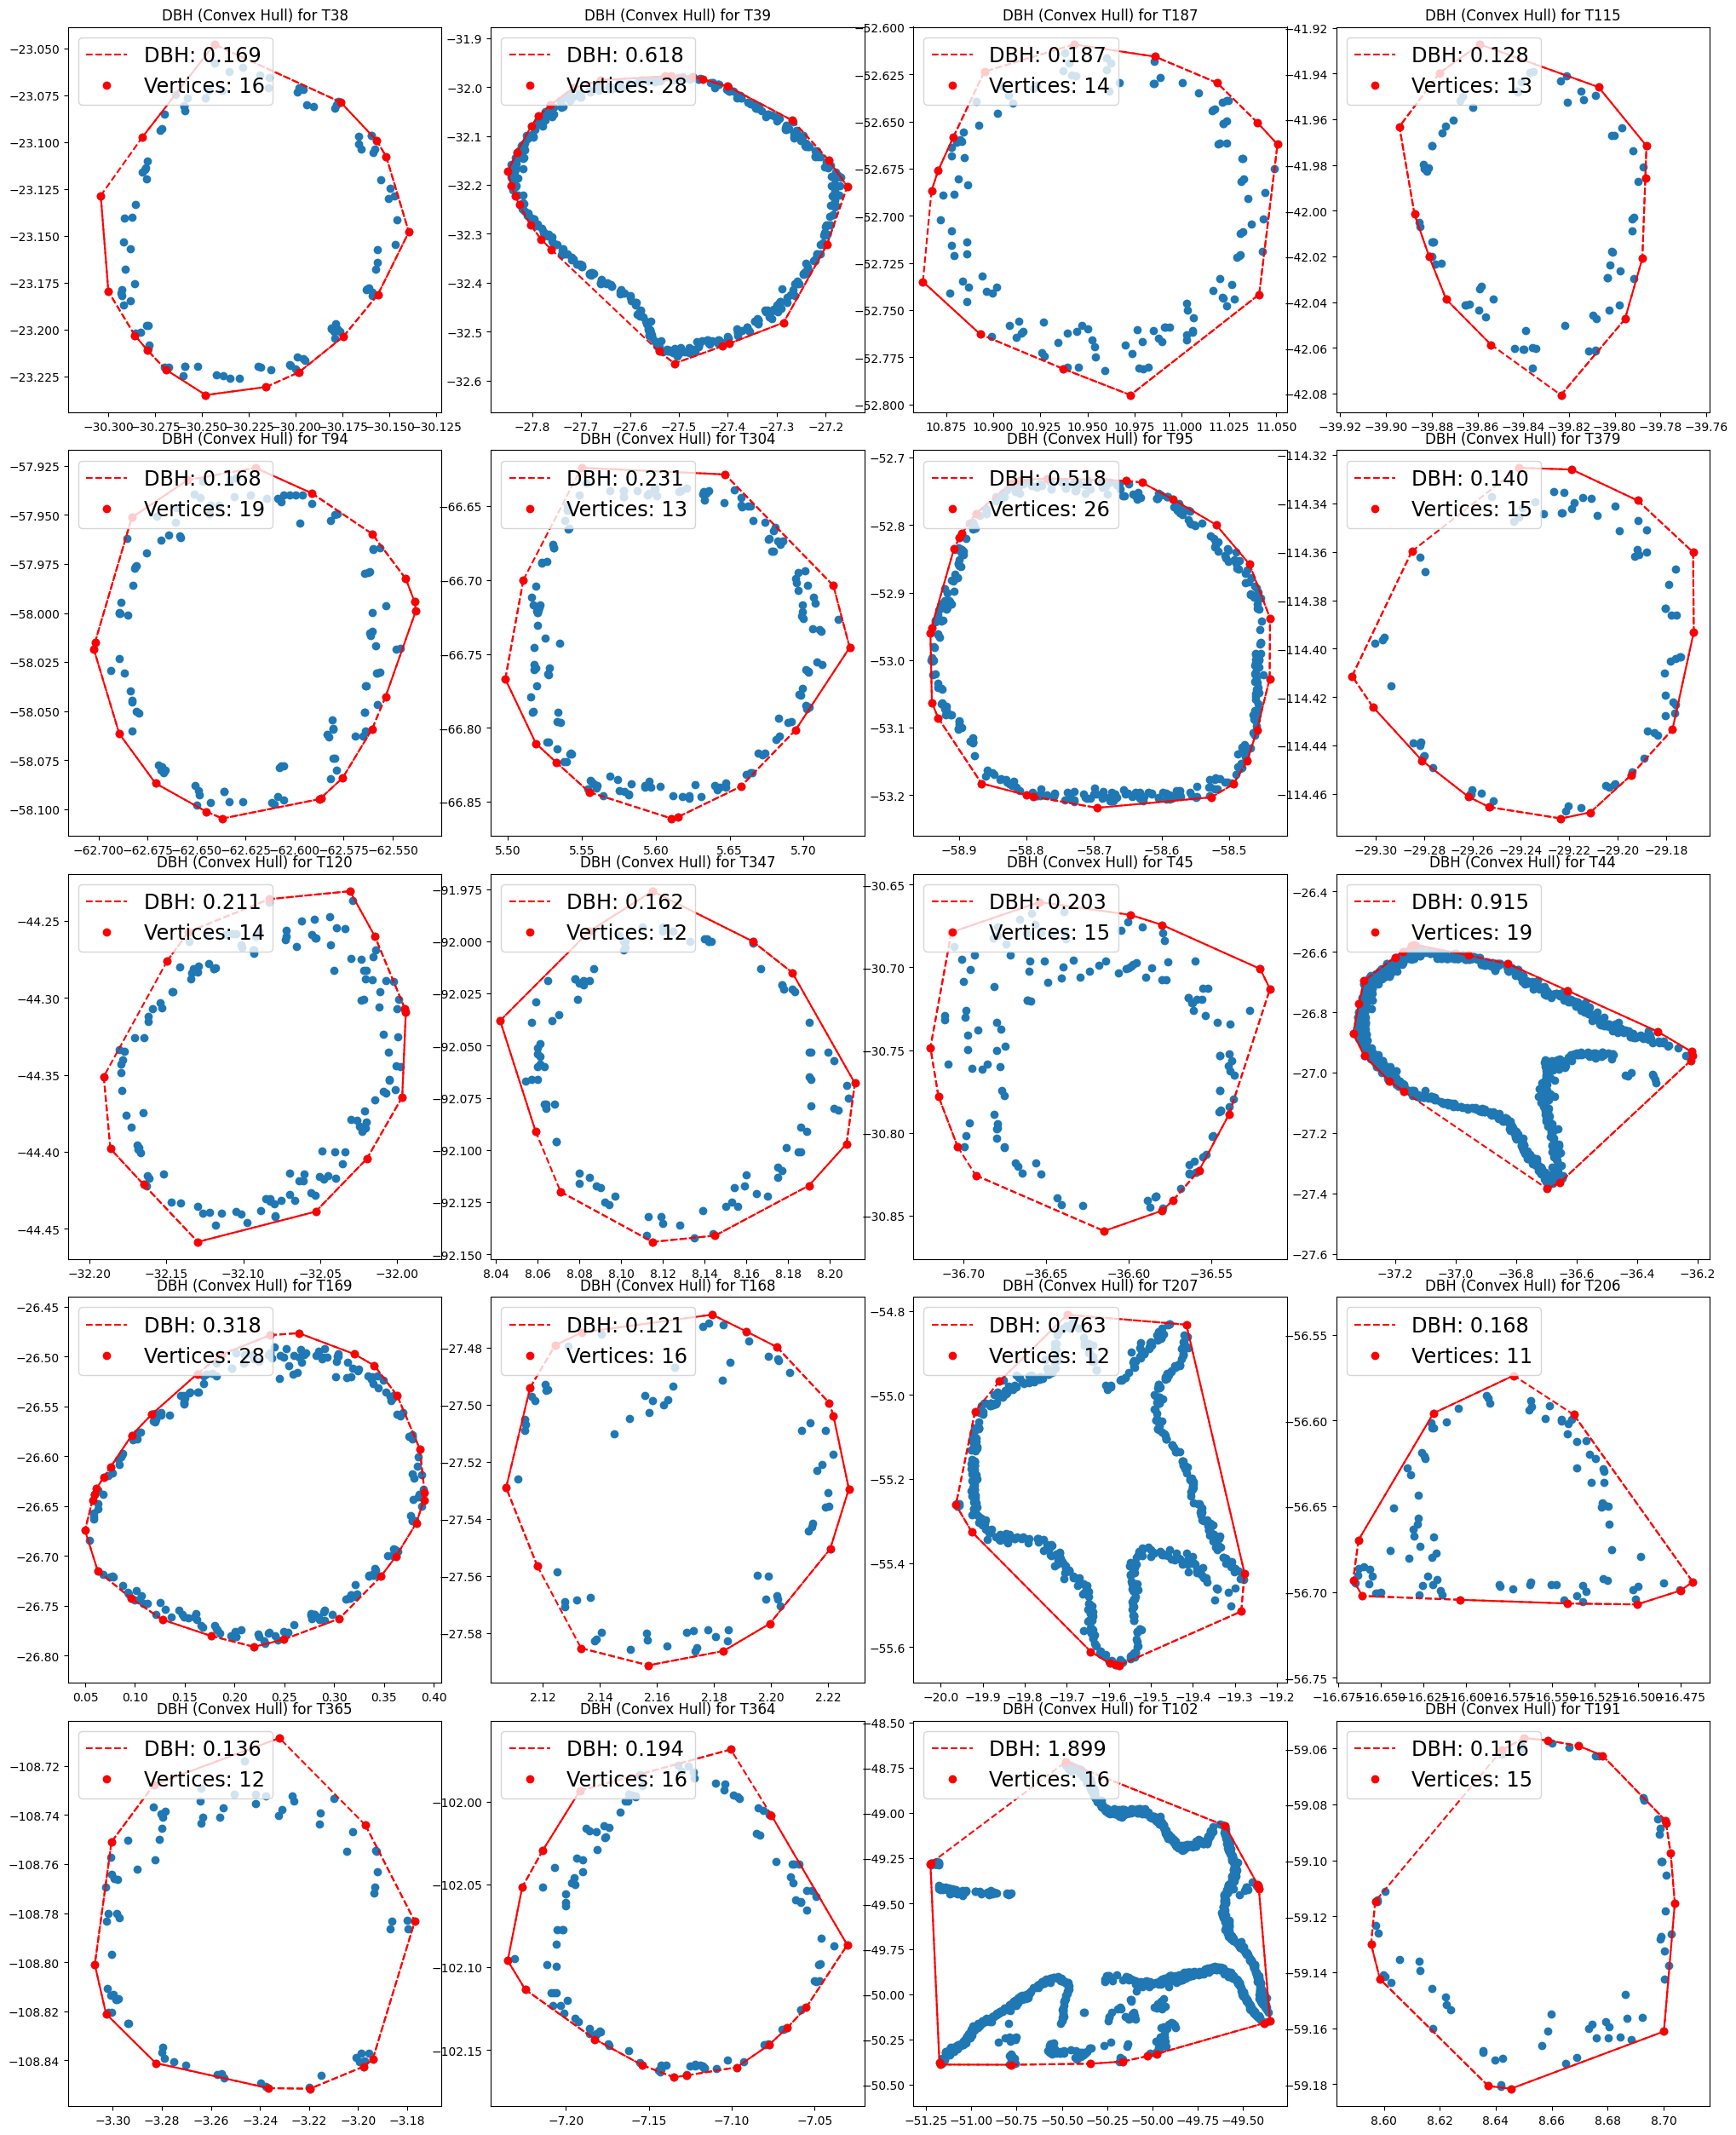

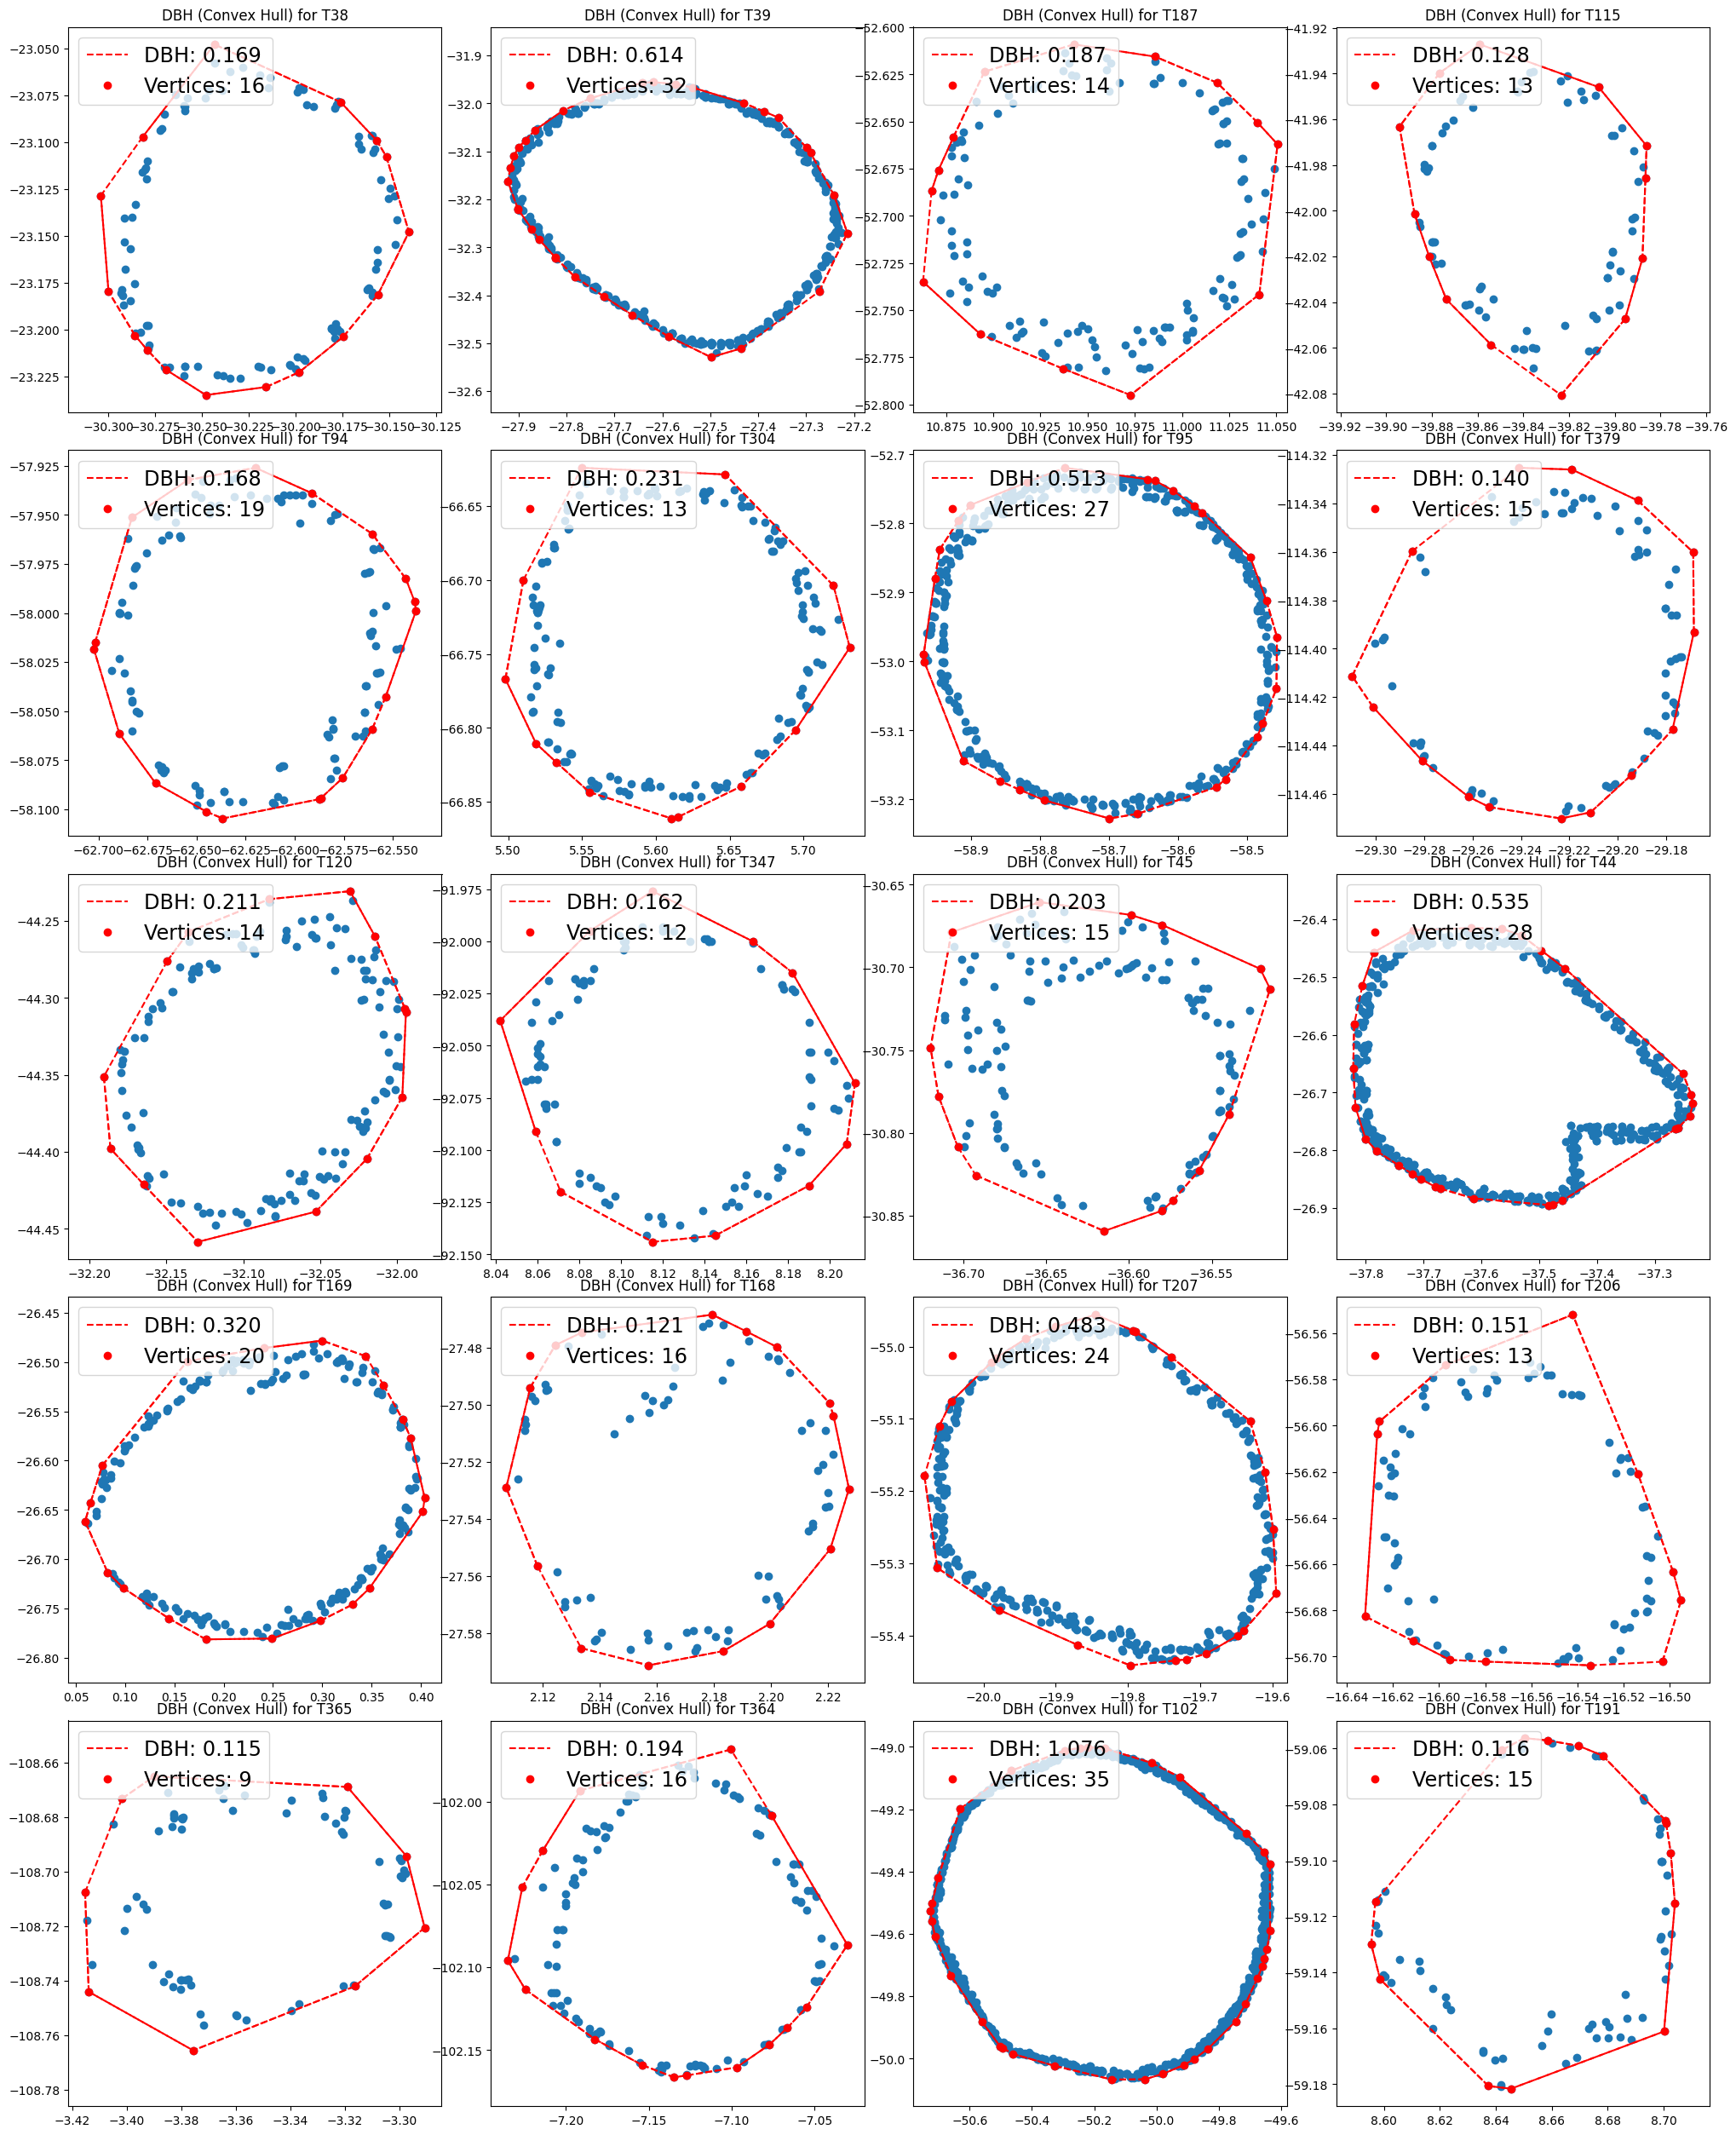

In [22]:
# plot convex hull results using fixed 1.3m dbh height
plot_convexhull(plotlist, trop_pts_path, ncols=4, fixedheight = True, hgt=1.3, hgtlist = hgt_dict)

# plot convex hull results 
plot_convexhull(plotlist, trop_pts_path, ncols=4, fixedheight = False, hgt=1.3, hgtlist = hgt_dict)

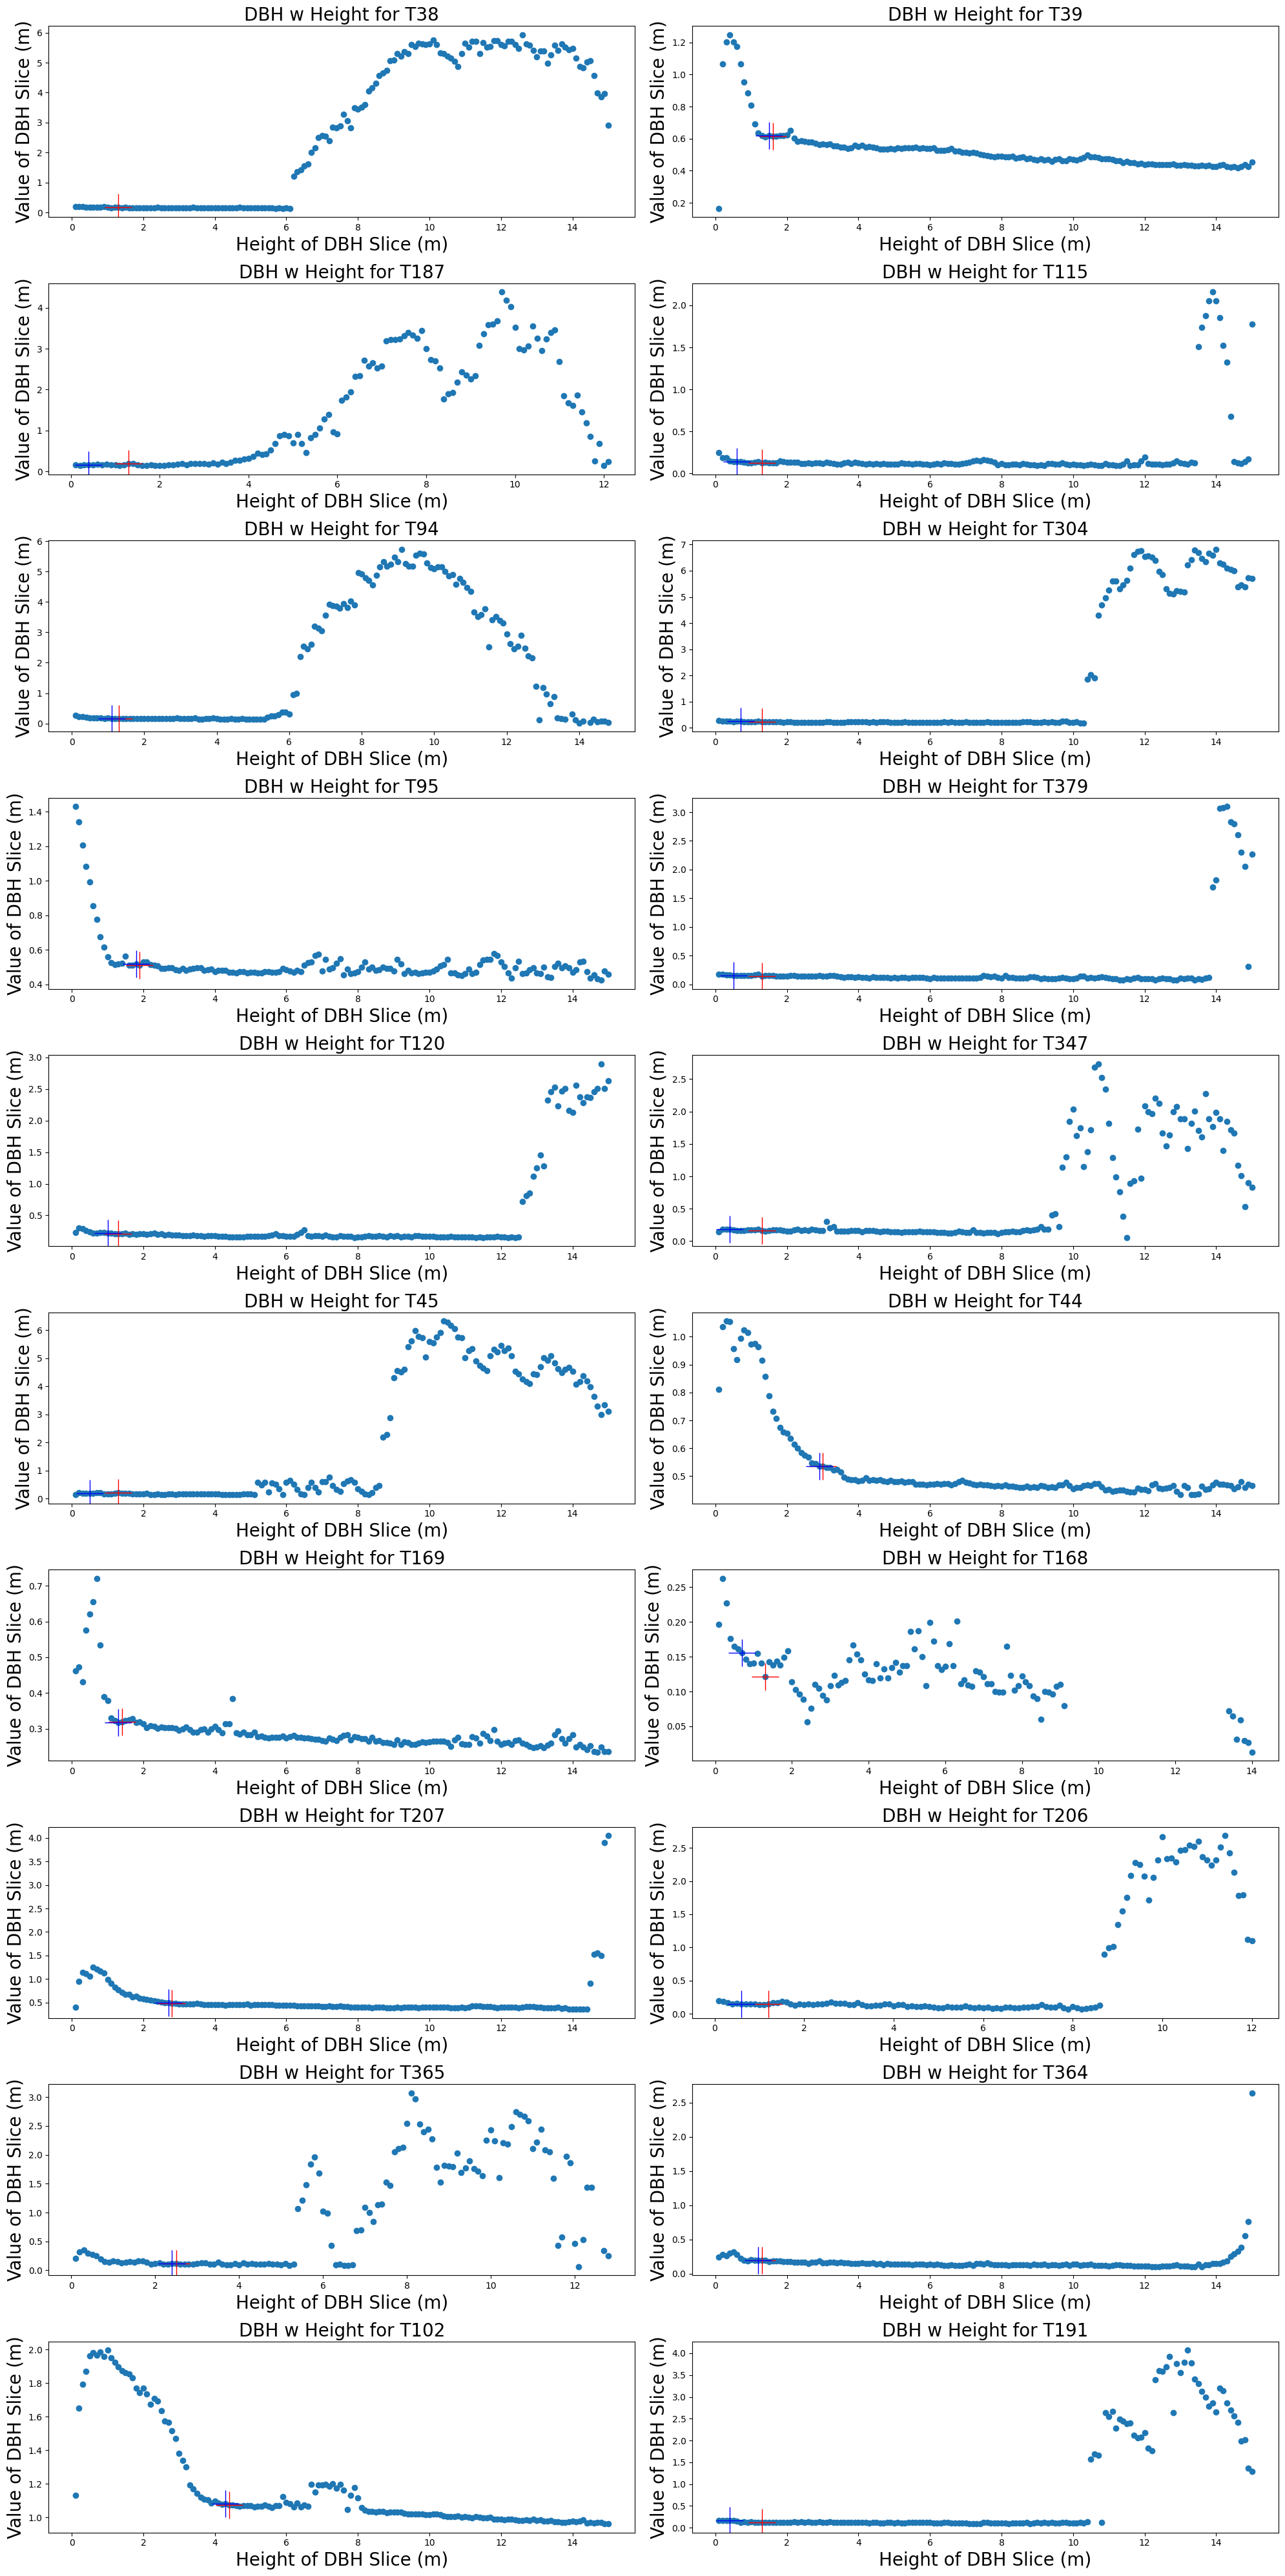

In [23]:
plot_iter_dbh(plotlist, trop_pts_path, ncols = 2, step=0.1, slope_thresh=0.1)

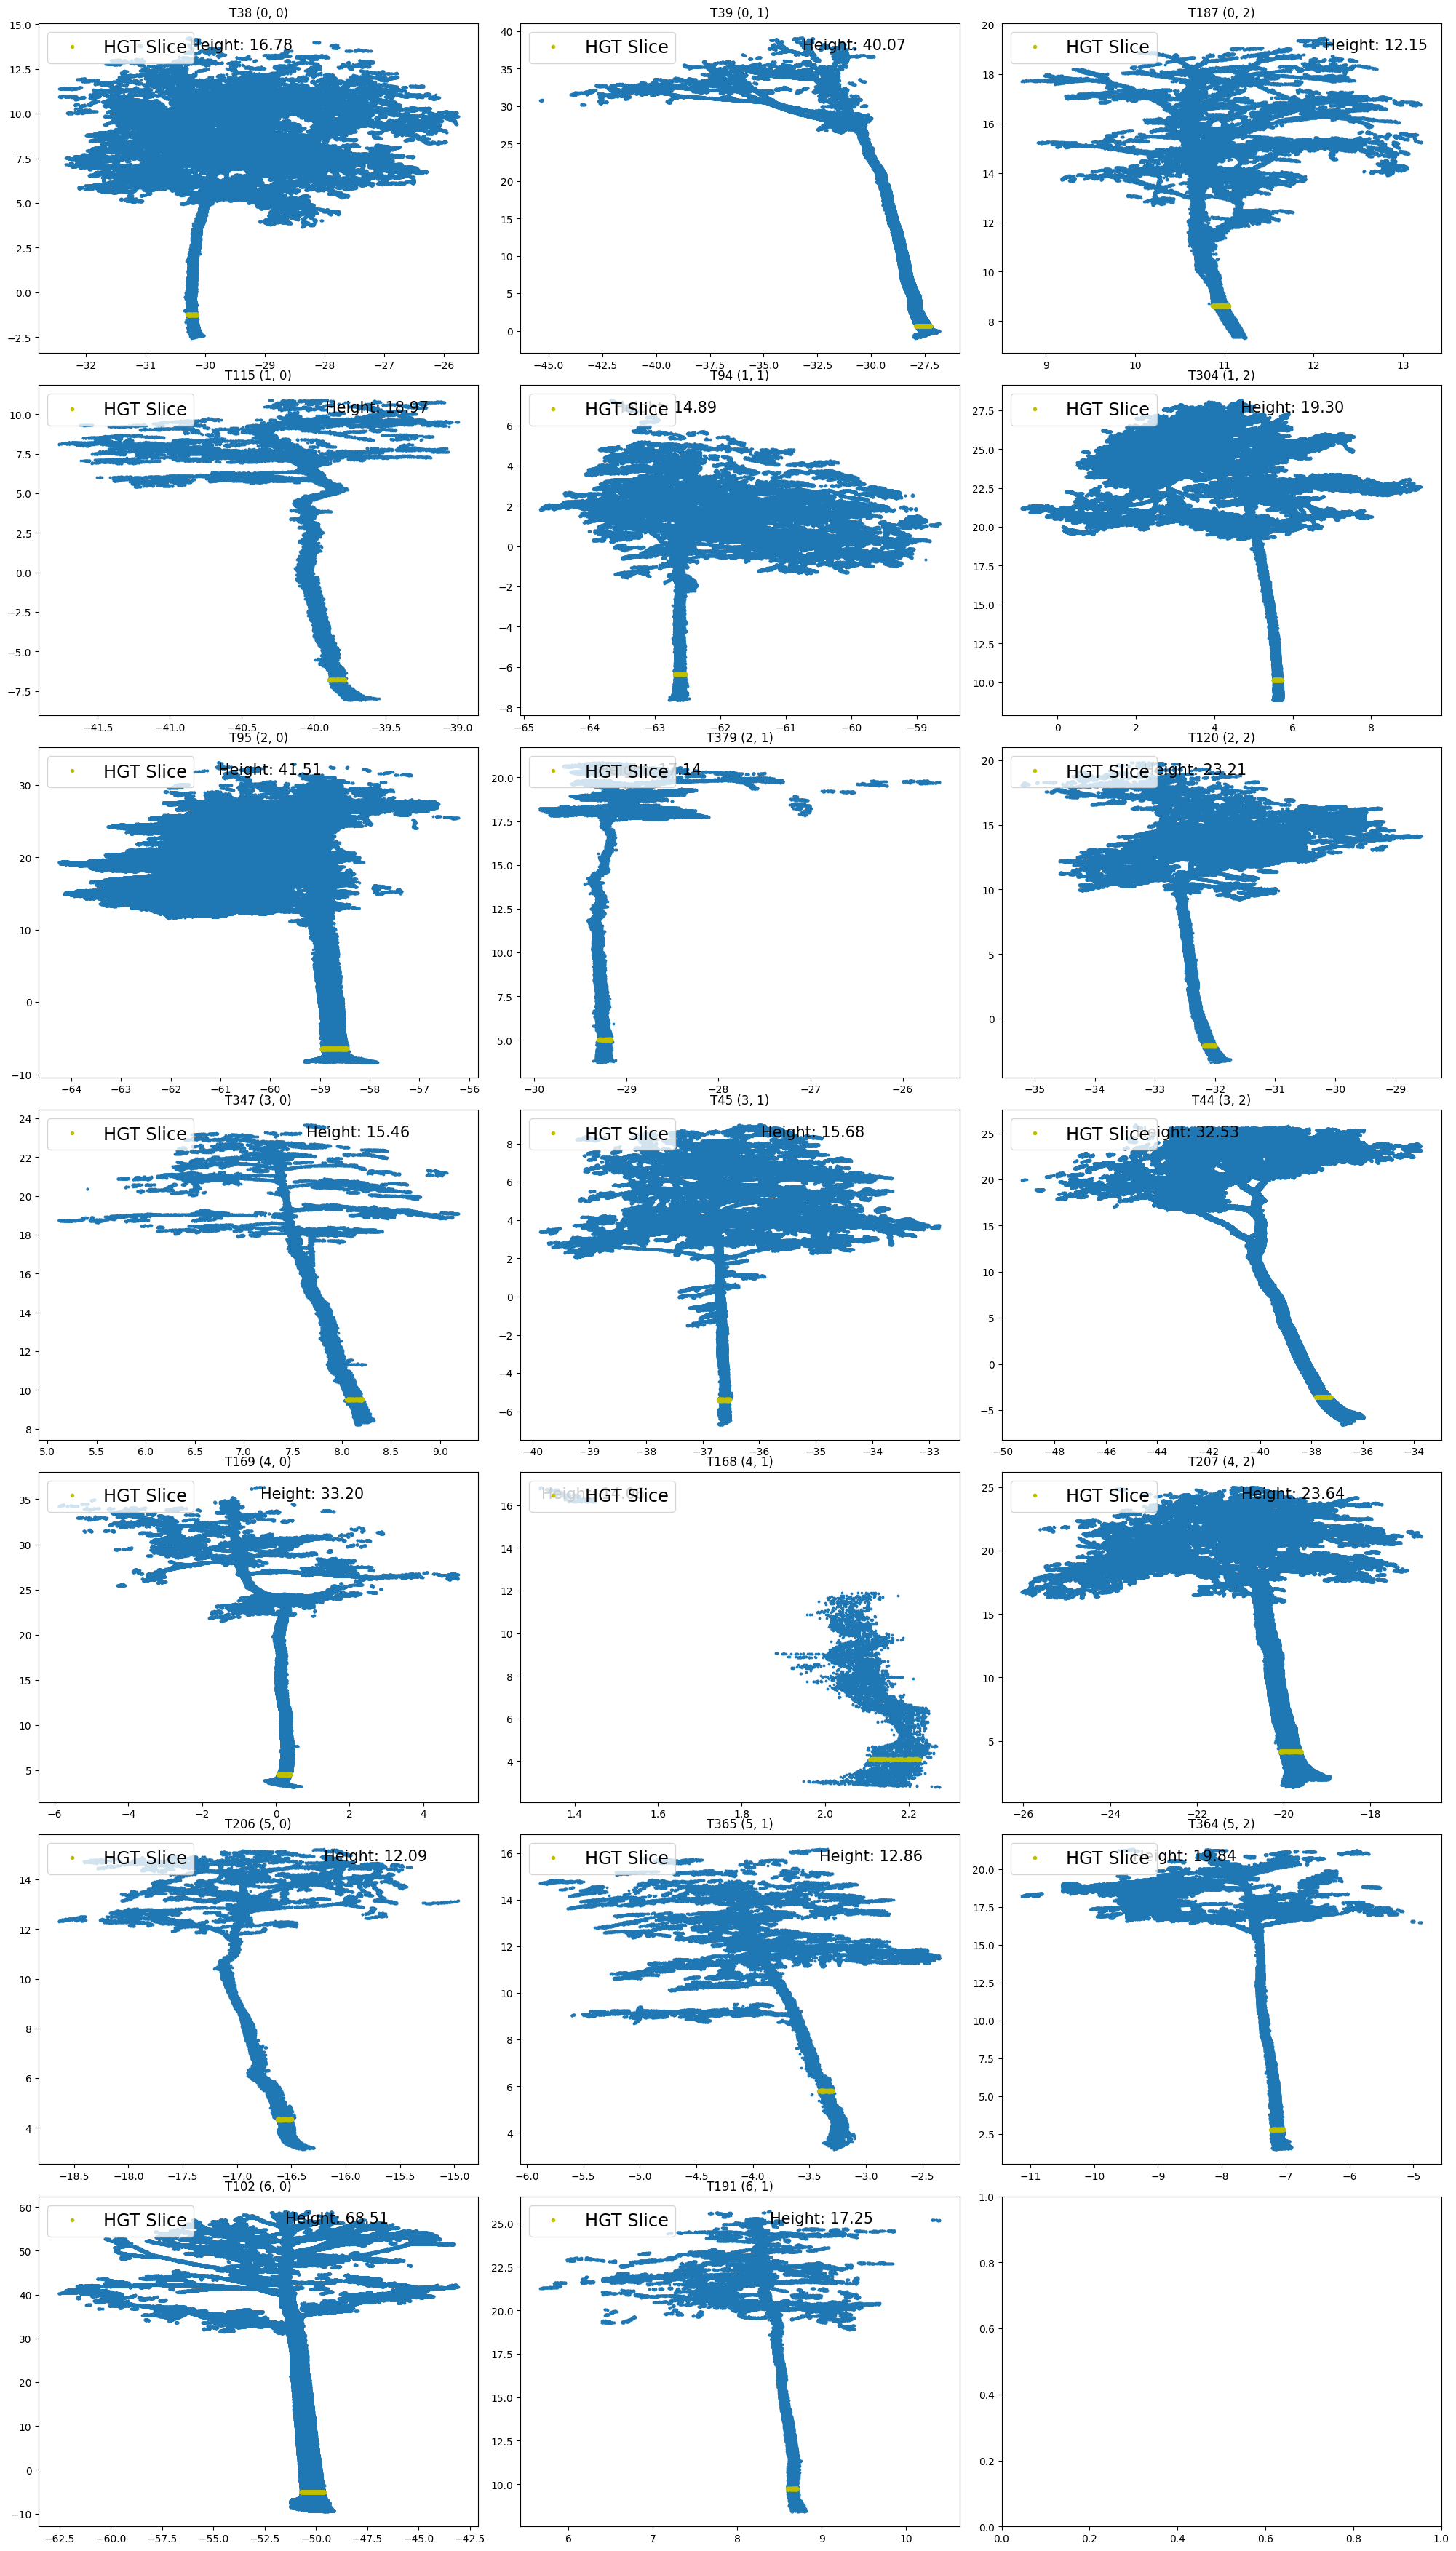

In [24]:
plot2D(plotlist, trop_pts_path, ncols=3, dbh=False, iterdbh=True, hgtlist = hgt_dict)

# Sensitivity

In [45]:
# create empty dictionaries to hold data
hgt_dict = {}
dbh_13_dict = {}
dbh_adj_dict = {}

# set list of trees to run convex hull on 
treelist = trop_trees

# list of threshold values to test
slope_thresh = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
dbh_thresh = [2


# cycle through trees and fill dictionaries with optimal height and convex hull values
for tree in treelist:
    tree, tree_num = construct_treeid(tree, trop_pts_path)
    
    # calculate convex hull at 1.3m
    dbh_13, verts_13, pts_dbh_13, hull_13 = calc_convexhull(tree, trop_pts_path, hgt=1.3)
    dbh_13_dict[tree_num] = dbh_13
    
    # determine optimal height from which to calculate dbh
    hgt = get_dbh_hgt(tree, trop_pts_path, step=0.1, slope_thresh=slope_thresh, lim=12, dbh_thresh=dbh_thresh)
    hgt_dict[tree_num] = hgt
    
    #print(f'{tree_num} hgt: {hgt}')
    
    # calculate convex hull at optimal height 
    dbh_adj, verts_adj, pts_dbh_adj, hull_adj = calc_convexhull(tree, trop_pts_path, hgt=hgt)
    dbh_adj_dict[tree_num] = dbh_adj

# Predict DBH:

In [ ]:
treecsv = pd.read_csv(tree_csv_path)


treecsv = treecsv[['TLS_ID','stemlocx_[m]', 'stemlocy_[m]', 'DBH_TLS_[m]',
                    'Hgt_pts_[m]', 'VerticalCrownProjectedArea_pts_[m2]', 'Vol_QSM_avg_[m3]',
                    'Vol_QSM_D0_25mm_avg_[m3]', 'Vol_QSM_D25_50mm_avg_[m3]', 'Vol_QSM_D50_75mm_avg_[m3]',
                    'Vol_QSM_D75_100mm_avg_[m3]', 'Vol_QSM_D100_200mm_avg_[m3]', 'Vol_QSM_D200_500mm_avg_[m3]',
                    'Vol_QSM_D500_1000mm_avg_[m3]', 'Vol_QSM_D1000mm_avg_[m3]']]


treedata = pd.merge(big_datadf, treecsv, on ='TLS_ID')

treedata.head()

## Compare Convex Hull with "DBH_TLS[m]"

In [ ]:
# select only single stem trees from csv 
#ss_treedata = treecsv[treecsv[['TLS_ID']].apply(lambda x: x[-1].isdigit(), axis=1)]

#smalltrees = treedata[treedata['DBH_CV']<4]

plt.figure(figsize=(10,7))
plt.scatter(treedata['dbh_cv'], treedata['DBH_TLS_[m]'])
plt.xlabel('DBH from Convex Hull', fontsize=20)
plt.ylabel('DBH from TLS', fontsize=20)


## Random Forest (Predicting DBH from QSMs)

In [ ]:
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Labels are the values we want to predict
labels = np.array(treedata['dbh_cv'])

# Remove the labels from the features
# axis 1 refers to the columns
features = treedata.drop(['TLS_ID','dbh_cv', 'DBH_TLS_[m]'], axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)



In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')



In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
#rf_results = pd.DataFrame(mape, predictions, test_labels)

rf_results = pd.DataFrame({'mape': mape, 'errors': errors,'predictions': predictions, 'test_labels': test_labels}, columns=['mape', 'errors', 'predictions', 'test_labels'])

plt.figure(figsize=(10,7))
plt.scatter(rf_results['predictions'], rf_results['test_labels'])
plt.xlabel('Predictions (DBH)', fontsize=20)
plt.ylabel('Measured Values (DBH)', fontsize=20)


In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(rf_results['test_labels'], rf_results['errors'])
plt.xlabel('Measured Values (DBH)', fontsize=20)
plt.ylabel('Errors', fontsize=20)

In [ ]:
# merge rf results back with original dataset
#https://stackoverflow.com/questions/40729162/merging-results-from-model-predict-with-original-pandas-dataframe
# TODO: in final - re-run model on full dataset and split into training vs testing

df_out = pd.merge(treedata,rf_results[['mape', 'errors', 'predictions']],how = 'left',left_index = True, right_index = True)

#rf_results.shape
df_out.head(150)

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df_out['verts'], df_out['errors'])
plt.xlabel('DBH Verts', fontsize=20)
plt.ylabel('Errors', fontsize=20)